In [71]:
import numpy as np
import scipy.stats as stats
# import math
import gpflow
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, Exponentiation,RationalQuadratic, WhiteKernel
import random

In [72]:
def generate_fake_data(xmin, xmax, n_samples, polynomial_degree, noise_level):
    x = [random.uniform(xmin, xmax) for _ in range(n_samples)]
    # Generate random noise of the same length as x
    noise = np.random.normal(scale=noise_level, size=n_samples)
    # Generate the y values according to a polynomial equation with some added noise
    y = np.polyval(np.random.randn(polynomial_degree + 1), x) + noise
    return np.array(x), np.array(y)

In [73]:
x,y = generate_fake_data(0, 1, 10, 2, 0.1)

### Step 1: GP Fit

In [74]:
def GPR(X, Y, kernel= None):
    """
    Fit GP to demand
    run once per product

    :param X: X values with shape (-1, 1)
    :param Y: Y values with shape (-1, 1)
    :param kernel: kernel for the GP
    :return: GPR model
    """

    kernel = kernel
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gaussian_process.fit(X, Y)
    return gaussian_process

model = GPR(x.reshape(-1,1),y.reshape(-1,1), kernel = 1 * RationalQuadratic(alpha= 10, length_scale=100) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e2)))
print(model)

GaussianProcessRegressor(kernel=1**2 * RationalQuadratic(alpha=10, length_scale=100) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)


### Test Step 1

In [75]:
### Plot model to check
Xplot = np.linspace(-0.1, 1.1, 100)
f_mean, f_var = model.predict(Xplot.reshape(-1,1), return_std=True)

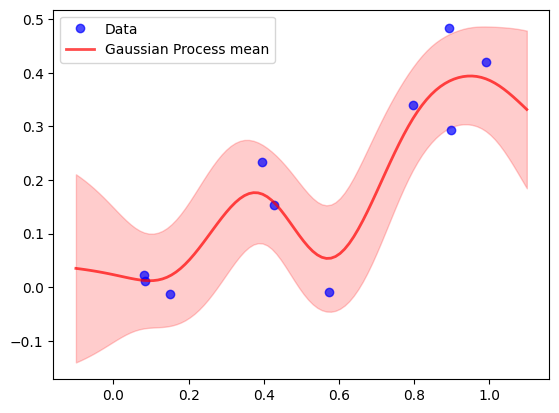

In [76]:
plt.plot(x, y, 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, f_mean, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, f_mean - f_var, f_mean + f_var, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend(); plt.show();

### Step 2 : Sample demand from GP
We use 2 products here to make things simpler

In [88]:
%%capture
### kernel
kernel = 1 * RationalQuadratic(alpha= 10, length_scale=100) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e2))
### generate datasets for both products
Ds = [generate_fake_data(0, 1, 10, 2, 0.1) for _ in range(2)]
### generate GPs for both products
GPs = [GPR(Ds[i][0].reshape(-1,1), Ds[i][1].reshape(-1,1), kernel = kernel) for i in range(2)]

In [89]:
### Plot model to check
Xplot = np.linspace(-0.1, 1.1, 100)
mean0, std0 = GPs[0].predict(Xplot.reshape(-1,1), return_std=True)
mean1, std1 = GPs[1].predict(Xplot.reshape(-1,1), return_std=True)

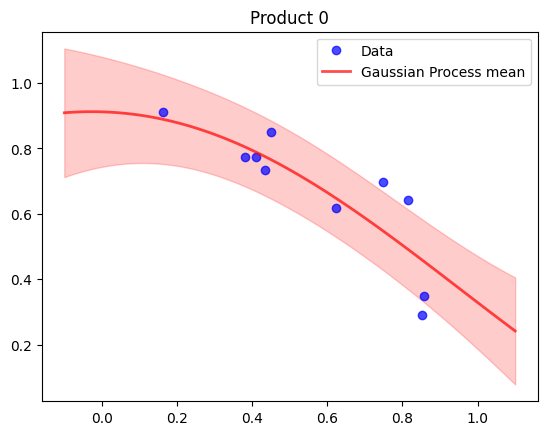

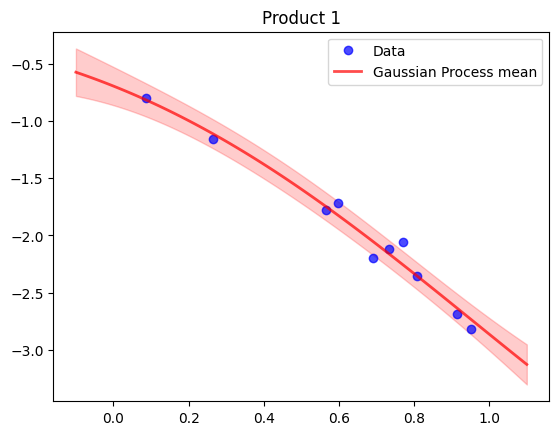

In [90]:
plt.figure()
plt.title('Product 0')
plt.plot(Ds[0][0], Ds[0][1], 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, mean0, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, mean0 - std0, mean0 + std0, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend()
plt.show()

plt.figure()
plt.title('Product 1')
plt.plot(Ds[1][0], Ds[1][1], 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, mean1, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, mean1 - std1, mean1 + std1, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend()
plt.show()

#### Sample for each price vector

In [218]:
### assume we only offer prices 0.1, 0.5, 0.7 --> get all possible price combinations
import itertools

def get_unique_permutations(lst, length):
    """
    Returns a list of all possible unique permutations of a given length of elements
    in a given list.
    """
    permutations = list(itertools.permutations(lst, length))
    unique_permutations = list(set(permutations))
    result = [list(x) for x in unique_permutations]
    return result

price_vectors = get_unique_permutations([0.1, 0.2, 0.3], length=2)

In [229]:
evaluated_y = []
for prod in range(2):
    # Generate samples from posterior distribution. One for each price vector
    y_hat_samples = GPs[prod].sample_y(Xplot.reshape(-1,1), n_samples=len(price_vectors), random_state=None) # no fixed behaviour!
    # for each price vector evaluate demand using the correct GP sample. i.e for 0th element of each price vector, evaluate the GP[0] sample
    # for the 1st element of each price vector, evaluate GP[1] and so on
    evaluated_y.append([np.interp(price_vectors[i][prod], Xplot, y_hat_samples[:,i]) for i in range(len(price_vectors))])

# combine indexes together to get back to price pairs
evaluations = [list(i) for i in list(zip(*evaluated_y))]

In [231]:
evaluations, price_vectors

([[0.94513578990521, -1.1930866041122825],
  [0.8631401678795929, -0.8128865400930125],
  [0.8734364733953054, -1.0211587656983374],
  [0.7533329397840367, -1.0970821317033352],
  [0.9924939698793915, -0.7768427023615464],
  [0.722368793019086, -1.1220758378062594]],
 [[0.2, 0.3], [0.3, 0.1], [0.3, 0.2], [0.1, 0.2], [0.2, 0.1], [0.1, 0.3]])

In [198]:
evaluated_y

[[1.00852420972091,
  0.7002909068607652,
  0.7578847237777027,
  0.7901287007672279,
  0.521391619554954,
  0.4921716567741554],
 [-1.5977877681422448,
  -2.073881854478585,
  -0.927300109008718,
  -2.0499764926989847,
  -1.112451566148014,
  -1.7171318330689411]]